In [1]:
import itertools
import os

import jax
import jax.numpy as jnp
from jax import vmap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.collections as mcoll
import matplotlib.patches as mpatches
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

from fbpinns.domains import RectangularDomainND
from fbpinns.networks import FCN, SIREN, FourierFCN
from fbpinns.trainers import get_inputs, FBPINN_model_jit
from fbpinns.analysis import load_model
from fbpinns.util.logger import logger
from fbpinns.util.jax_util import tree_index
logger.setLevel("CRITICAL")

from problems import Laplace1D_quadratic, Laplace2D_quadratic, Laplace2D_multiscale, Helmholtz2D
from plot import exact_solution, FBPINN_solution, PINN_solution
from plot import load_FBPINN as load_FBPINN_
from plot import load_PINN as load_PINN_
from plot import load_SelfAdaptivePINN as load_SelfAdaptivePINN_

In [2]:
def load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds):
    "Loads FBPINNs over multiple seeds, and returns average losses / times"
    ts, l1ns = [],[]
    for seed in range(n_seeds):
        c, model, i, t, l1n = load_FBPINN_(tag, problem, network, l, w, h, p, n, lr, seed)
        ts.append(t); l1ns.append(l1n)
    ts, l1ns = np.stack(ts, axis=1), np.stack(l1ns, axis=1)
    t_mu, t_sd, t_mi, t_ma = ts.mean(axis=1), ts.std(axis=1), ts.min(axis=1), ts.max(axis=1)
    l1_mu, l1_sd, l1_mi, l1_ma = l1ns.mean(axis=1), l1ns.std(axis=1), l1ns.min(axis=1), l1ns.max(axis=1)
    print(i[-1], l1ns.shape, l1ns[-1].min(), l1ns[-1].max(), ts[-1].min(), ts[-1].max(), c.run)
    return c, model, i, (t_mu, t_sd, t_mi, t_ma), (l1_mu, l1_sd, l1_mi, l1_ma)

def load_PINN(tag, problem, network, h, p, n, lr, n_seeds):
    "Loads PINNs over multiple seeds, and returns average losses / times"
    ts, l1ns = [],[]
    for seed in range(n_seeds):
        c, model, i, t, l1n = load_PINN_(tag, problem, network, h, p, n, lr, seed)
        ts.append(t); l1ns.append(l1n)
    ts, l1ns = np.stack(ts, axis=1), np.stack(l1ns, axis=1)
    t_mu, t_sd, t_mi, t_ma = ts.mean(axis=1), ts.std(axis=1), ts.min(axis=1), ts.max(axis=1)
    l1_mu, l1_sd, l1_mi, l1_ma = l1ns.mean(axis=1), l1ns.std(axis=1), l1ns.min(axis=1), l1ns.max(axis=1)
    print(i[-1], l1ns.shape, l1ns[-1].min(), l1ns[-1].max(), ts[-1].min(), ts[-1].max(), c.run)
    if "Fourier" in c.run: print(c.network_init_kwargs["mu"], c.network_init_kwargs["sd"], c.network_init_kwargs["n_features"])
    return c, model, i, (t_mu, t_sd, t_mi, t_ma), (l1_mu, l1_sd, l1_mi, l1_ma)

def load_SelfAdaptivePINN(tag, problem, network, h, p, n, lr, n_seeds):
    "Loads SelfAdaptivePINNs over multiple seeds, and returns average losses / times"
    ts, l1ns = [],[]
    for seed in range(n_seeds):
        c, model, i, t, l1n = load_SelfAdaptivePINN_(tag, problem, network, h, p, n, lr, seed)
        ts.append(t); l1ns.append(l1n)
    ts, l1ns = np.stack(ts, axis=1), np.stack(l1ns, axis=1)
    t_mu, t_sd, t_mi, t_ma = ts.mean(axis=1), ts.std(axis=1), ts.min(axis=1), ts.max(axis=1)
    l1_mu, l1_sd, l1_mi, l1_ma = l1ns.mean(axis=1), l1ns.std(axis=1), l1ns.min(axis=1), l1ns.max(axis=1)
    print(i[-1], l1ns.shape, l1ns[-1].min(), l1ns[-1].max(), ts[-1].min(), ts[-1].max(), c.run)
    if "Fourier" in c.run: print(c.network_init_kwargs["mu"], c.network_init_kwargs["sd"], c.network_init_kwargs["n_features"])
    return c, model, i, (t_mu, t_sd, t_mi, t_ma), (l1_mu, l1_sd, l1_mi, l1_ma)

def plot_l1(i, l1s, label=None, marker=None, color=None, s=None, lw=None):
    l1_mu, _, l1_mi, l1_ma = l1s
    plt.plot(i, l1_mu, label=label, c=color, lw=lw)
    plt.fill_between(i, l1_mi, l1_ma, lw=0, color=color, alpha=0.2)
    if marker is not None:
        plt.scatter(i[-1], l1_mu[-1], marker=marker, edgecolors="none", facecolors=color, s=s)

def scatter_l1(ts, l1s, label=None, marker=None, color=None, s=None, lw=None):
    (t_mu, _, t_mi, t_ma), (l1_mu, _, l1_mi, l1_ma) = ts, l1s
    plt.errorbar(t_mu[-1], l1_mu[-1], 
                 xerr=np.array([[t_mu[-1]-t_mi[-1]],[t_ma[-1]-t_mu[-1]]]),
                 yerr=np.array([[l1_mu[-1]-l1_mi[-1]],[l1_ma[-1]-l1_mu[-1]]]),
                 ecolor=color,
                 marker=marker,
                 markeredgecolor="none",
                 markerfacecolor=color,
                 label=label,
                 markersize=s,
                 lw=0,
                 elinewidth=lw)

def fix_plot(legend=True):
    if legend:
        plt.legend()
    plt.yscale("log")
    plt.xlabel("Training step")
    plt.ylabel("Normalised L1 test loss")

def fix_plot3(legend=True):
    if legend:
        plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Total time elapsed (s)")
    plt.ylabel("Normalised L1 test loss")

def fix_plot2():
    plt.xlabel("$x_1$", fontsize="large")
    plt.ylabel("$x_2$", fontsize="large")
    plt.xlim(0,1); plt.ylim(0,1)
    
def fix_plot4():
    plt.xticks([]); plt.yticks([])
    plt.xlim(0,1); plt.ylim(0,1)

def savefig(tag2=""):
    plt.savefig(f"plots/{problem.__name__}-{tag}{tag2}.pdf", bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

colors1 = cm.Blues(np.linspace(0.2,0.95,6))
colors2 = cm.Greens(np.linspace(0.2,0.95,6))
colors3 = cm.Reds(np.linspace(0.2,0.95,6))
colors4 = cm.Greys(np.linspace(0.2,0.95,6))
colors5 = cm.Purples(np.linspace(0.2,0.95,6))
colorss = [colors1, colors2, colors3, colors4, colors5]

## Laplace - 1D/2D schematic

20000.0 (41, 10) 1.4942763e-05 0.00034433312 22.994701 25.1329 FBPINN_ablation_Laplace1D_quadratic_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 10) 1.590491e-05 0.00027679908 28.506802 33.11853 FBPINN_ablation_Laplace2D_quadratic_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9


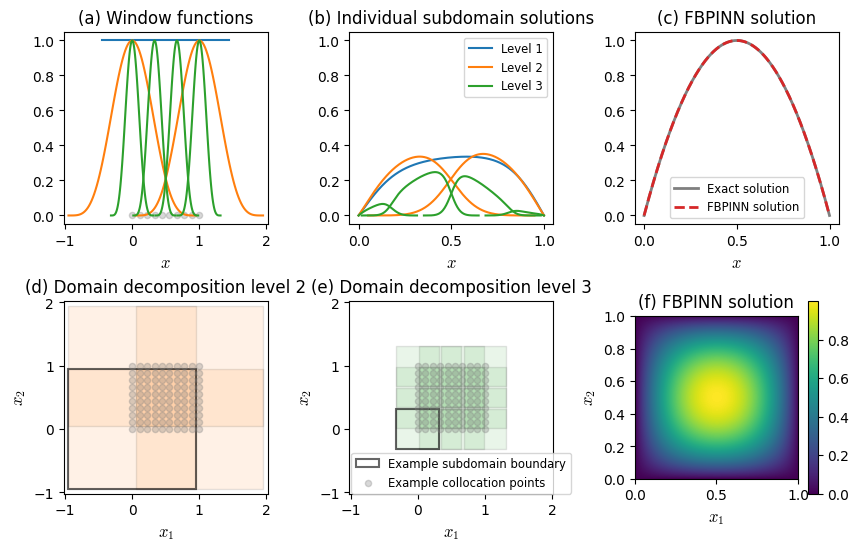

In [3]:
n_seeds = 10


tag = "ablation"
problem=Laplace1D_quadratic
network = FCN
lr = 1e-3
l = [2**i for i in range(3)]
w, h, p = 1.9,1,16
n = (80,)


c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
u_exact = exact_solution(c, model)

all_params, active = model[1], model[3]
domain, problem, decomposition, network = c.domain, c.problem, c.decomposition, c.network
model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)

x_batch = x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=c.n_test)

takes, all_ims, (_, _, _, cut_all, _) = get_inputs(x_batch, active, all_params, decomposition)
    
# get FBPINN solution using test data
all_params_cut = {"static":cut_all(all_params["static"]),
                  "trainable":cut_all(all_params["trainable"])}
u_test, wp_test_, us_test_, ws_test_, us_raw_test_ = FBPINN_model_jit(all_params_cut, x_batch_test, takes, model_fns, verbose=False)

m, ud, n = all_params["static"]["decomposition"]["m"], all_params["static"]["problem"]["dims"][0], x_batch_test.shape[0]

us_test = jnp.full((m, n, ud), jnp.nan)
us_test = us_test.at[all_ims[takes[0]], takes[1], :].set(us_test_)

ws_test = jnp.full((m, n, 1), jnp.nan)
ws_test = ws_test.at[all_ims[takes[0]], takes[1], :].set(ws_test_)

us_raw_test = jnp.full((m, n, ud), jnp.nan)
us_raw_test = us_raw_test.at[all_ims[takes[0]], takes[1], :].set(us_raw_test_)

# apply POU
us_test = us_test.at[all_ims[takes[0]], takes[1], :].divide(wp_test_[takes[2]])/takes[4]
ws_test = ws_test.at[all_ims[takes[0]], takes[1], :].divide(wp_test_[takes[2]])/takes[4]

# apply constraining operator
us_test = vmap(model_fns[-1], in_axes=(None,None,0))(all_params, x_batch_test, us_test)


x_batch_ = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(10,))

cs = ["tab:blue", "tab:orange", "tab:green"]
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
for im in range(all_params["static"]["decomposition"]["m"]):
    params_ = {"static":{"decomposition":{"subdomain":
                tree_index(all_params["static"]["decomposition"]["subdomain"], im)}}}
    xmin, xmax, wmin, wmax, *_ = params_["static"]["decomposition"]["subdomain"]["params"]
    x = np.linspace(xmin[0], xmax[0], 100).reshape((-1,1))
    w = jax.vmap(decomposition.window_fn, in_axes=(None,0))(params_, x)
    plt.plot(x, w, color=cs[all_params["static"]["decomposition"]["subdomain"]["pou"][im,0].astype(int)])
plt.scatter(x_batch_, jnp.zeros_like(x_batch_), s=20, alpha=0.3, c="tab:grey")
plt.xlim(-1.02, 2.02)
plt.title("(a) Window functions")
plt.xlabel("$x$", fontsize="large")
plt.subplot(2,3,3)
plt.plot(x_batch, u_exact, lw=2, label="Exact solution", color="tab:grey")
plt.plot(x_batch, u_test, "--", lw=2, label="FBPINN solution", color="tab:red")
plt.title("(c) FBPINN solution")
plt.xlabel("$x$", fontsize="large")
ylim = plt.ylim()
plt.legend(fontsize="small")
plt.subplot(2,3,2)
for im,u in enumerate(us_test):
    il = all_params["static"]["decomposition"]["subdomain"]["pou"][im,0].astype(int)
    label,c = f"Level {il+1}", cs[il]
    if im not in [0,1,5]: label=None
    plt.plot(x_batch, u, color=c, label=label)
#plt.plot(x_batch, jnp.nansum(us_test, axis=0), lw=4,label="test", zorder=-10)
plt.title("(b) Individual subdomain solutions")
plt.legend(fontsize="small")
plt.xlabel("$x$", fontsize="large")
plt.ylim(ylim)





tag = "ablation"
problem=Laplace2D_quadratic
network = FCN
l = [2**i for i in range(3)]
w, h, p = 1.9,1,16
n = (80,80)


c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
u_test = FBPINN_solution(c, model)

all_params, active = model[1], model[3]
domain, problem, decomposition, network = c.domain, c.problem, c.decomposition, c.network

xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
xmins, xmaxs, wmins, wmaxs, *_ = all_params["static"]["decomposition"]["subdomain"]["params"]


x_batch_ = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(10,10))

plt.subplot(2,3,4)
patches = []
for i in range(1,5):
    patches.append(mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                                     ))
    if i == 1:
        r = mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                               facecolor="none",
                               linewidth=1.5,
                               alpha=0.6,
                               edgecolor="k",
                                     )
plt.gca().add_collection(mcoll.PatchCollection(patches,
                                               alpha=0.1,
                                               edgecolor="k",
                                               facecolor="tab:orange"))
plt.gca().add_patch(r)
plt.scatter(x_batch_[:,0], x_batch_[:,1], s=20, alpha=0.3, c="tab:grey")
plt.xlim(-1.02, 2.02)
plt.ylim(-1.02, 2.02)
plt.xlabel("$x_1$", fontsize="large"); plt.ylabel("$x_2$", fontsize="large")
plt.title("(d) Domain decomposition level 2")
plt.subplot(2,3,5)
patches = []
for i in range(5,21):
    patches.append(mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                                     ))
    if i == 5:
        r = mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                               facecolor="none",
                               linewidth=1.5,
                               alpha=0.6,
                               edgecolor="k",
                               label="Example subdomain boundary"
                                     )
plt.gca().add_collection(mcoll.PatchCollection(patches,
                                               alpha=0.1,
                                               edgecolor="k",
                                               facecolor="tab:green"))
plt.gca().add_patch(r)
plt.scatter(x_batch_[:,0], x_batch_[:,1], s=20, alpha=0.3, c="tab:grey", label="Example collocation points")
plt.xlim(-1.02, 2.02)
plt.ylim(-1.02, 2.02)
plt.xlabel("$x_1$", fontsize="large"); plt.ylabel("$x_2$", fontsize="large")
plt.title("(e) Domain decomposition level 3")
plt.legend(loc=(0.01,0), fontsize="small")
plt.subplot(2,3,6)
plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
plt.colorbar()
plt.xlabel("$x_1$", fontsize="large"); plt.ylabel("$x_2$", fontsize="large")
plt.title("(f) FBPINN solution")

plt.subplots_adjust(hspace=0.4, wspace=0.4)
problem=Laplace1D_quadratic; tag = "domain"
savefig()
plt.show()

## Laplace - ablation tests

20000.0 (41, 10) 6.601979e-05 0.00071944424 25.008255 26.93733 FBPINN_ablation_Laplace2D_quadratic_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 10) 0.00011211193 0.0004009528 23.266539 29.062443 FBPINN_ablation_Laplace2D_quadratic_FCN_[2]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 10) 1.590491e-05 0.00027679908 28.506802 33.11853 FBPINN_ablation_Laplace2D_quadratic_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 10) 5.5446075e-05 0.00030421116 23.947216 26.939453 FBPINN_ablation_Laplace2D_quadratic_FCN_[4]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 10) 9.218091e-06 0.00012972653 33.031666 35.536983 FBPINN_ablation_Laplace2D_quadratic_FCN_[1, 2, 4, 8]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 10) 8.23216e-05 0.0005165275 24.092106 27.616703 FBPINN_ablation_Laplace2D_quadratic_FCN_[8]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-9
20000.0 (41, 

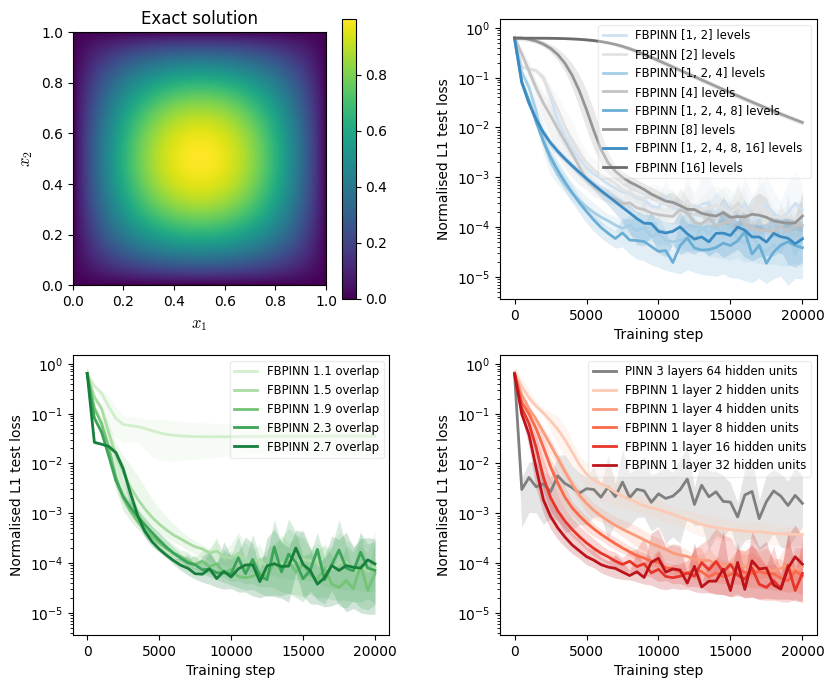

In [4]:
#########

network = FCN

## TEST 1: simple ablation tests
tag = "ablation"

# Laplace1D_quadratic ablation
domain=RectangularDomainND
domain_init_kwargs=dict(xmin=np.array([0.,]),
                        xmax=np.array([1.,]),)
problem=Laplace1D_quadratic
problem_init_kwargs=dict()
unnorm=(0.5, 0.375)# unnorm

n_steps=20000# number training steps
n=(80,)# number training points
n_test=(350,)# number test points
lr = 1e-3# learning rate

h=1

ls=[2, 3, 4, 5]# number of levels
ws=[1.1, 1.5, 1.9, 2.3, 2.7]# overlap width
ps=[2, 4, 8, 16, 32]# number of hidden units
p0=[3, 1.9, 16]

# Laplace2D_quadratic ablation
domain=RectangularDomainND
domain_init_kwargs=dict(xmin=np.array([0.,0]),
                        xmax=np.array([1.,1.]),)
problem=Laplace2D_quadratic

n=(80,80)# number training points
n_test=(350,350)# number test points

#########




# plot ablations
plt.figure(figsize=0.8*np.array([12,10]))

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,2)
for ip,l_ in enumerate(ls):
    l = [2**i for i in range(l_)]
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    plot_l1(i, l1s, label=f"FBPINN {l} levels ", color=colors1[ip], lw=2)
    if l_ != 0:
        l = [2**(l_-1)]
        c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
        plot_l1(i, l1s, label=f"FBPINN {l} levels ", color=colors4[ip], lw=2)
    
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
ylim = list(plt.ylim())
ylim[0] -= 1e-7
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,3)
for ip,w in enumerate(ws):
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    plot_l1(i, l1s, label=f"FBPINN {w} overlap", color=colors2[ip], lw=2)
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,4)
h,p=3,64
c, model, i, ts, l1s = load_PINN(tag, problem, network, h, p, n, lr, n_seeds)
plot_l1(i, l1s, label=f"PINN {h} layers {p} hidden units", color="tab:grey", lw=2)
h,p=1,16

for ip,p in enumerate(ps):
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    plot_l1(i, l1s, label=f"FBPINN {h} layer {p} hidden units", color=colors3[ip], lw=2)

fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

# plot exact solution
plt.subplot(2,2,1)
u_exact = exact_solution(c, model)
plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
plt.colorbar()
plt.title("Exact solution")
fix_plot2()

plt.subplots_adjust(hspace=0.2, wspace=0.35)
savefig()
plt.show()

## Laplace - strong scaling

30000.0 (61, 10) 0.8470243 1.7386479 183.91495 191.85384 FBPINN_strong_Laplace2D_multiscale_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_320-n_0.001-lr-9
30000.0 (61, 10) 1.5569531 9.993955 241.4368 246.20882 FBPINN_strong_Laplace2D_multiscale_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_320-n_0.001-lr-9
30000.0 (61, 10) 1.1201863 5.146667 278.38168 289.1075 FBPINN_strong_Laplace2D_multiscale_FCN_[1, 2, 4, 8]-levels_1.9-overlap_1-layers_16-hidden_320-n_0.001-lr-9
30000.0 (61, 10) 0.009128841 0.03334785 327.065 339.10675 FBPINN_strong_Laplace2D_multiscale_FCN_[1, 2, 4, 8, 16]-levels_1.9-overlap_1-layers_16-hidden_320-n_0.001-lr-9
30000.0 (61, 10) 0.001498724 0.0025381888 344.563 363.6304 FBPINN_strong_Laplace2D_multiscale_FCN_[1, 2, 4, 8, 16, 32]-levels_1.9-overlap_1-layers_16-hidden_320-n_0.001-lr-9
30000.0 (61, 10) 0.054961346 0.12562677 406.80417 417.28976 FBPINN_strong_Laplace2D_multiscale_FCN_[1, 2, 4, 8, 16, 32, 64]-levels_1.9-overlap_1-layers_16-hidden_320-n_0.001-lr-9

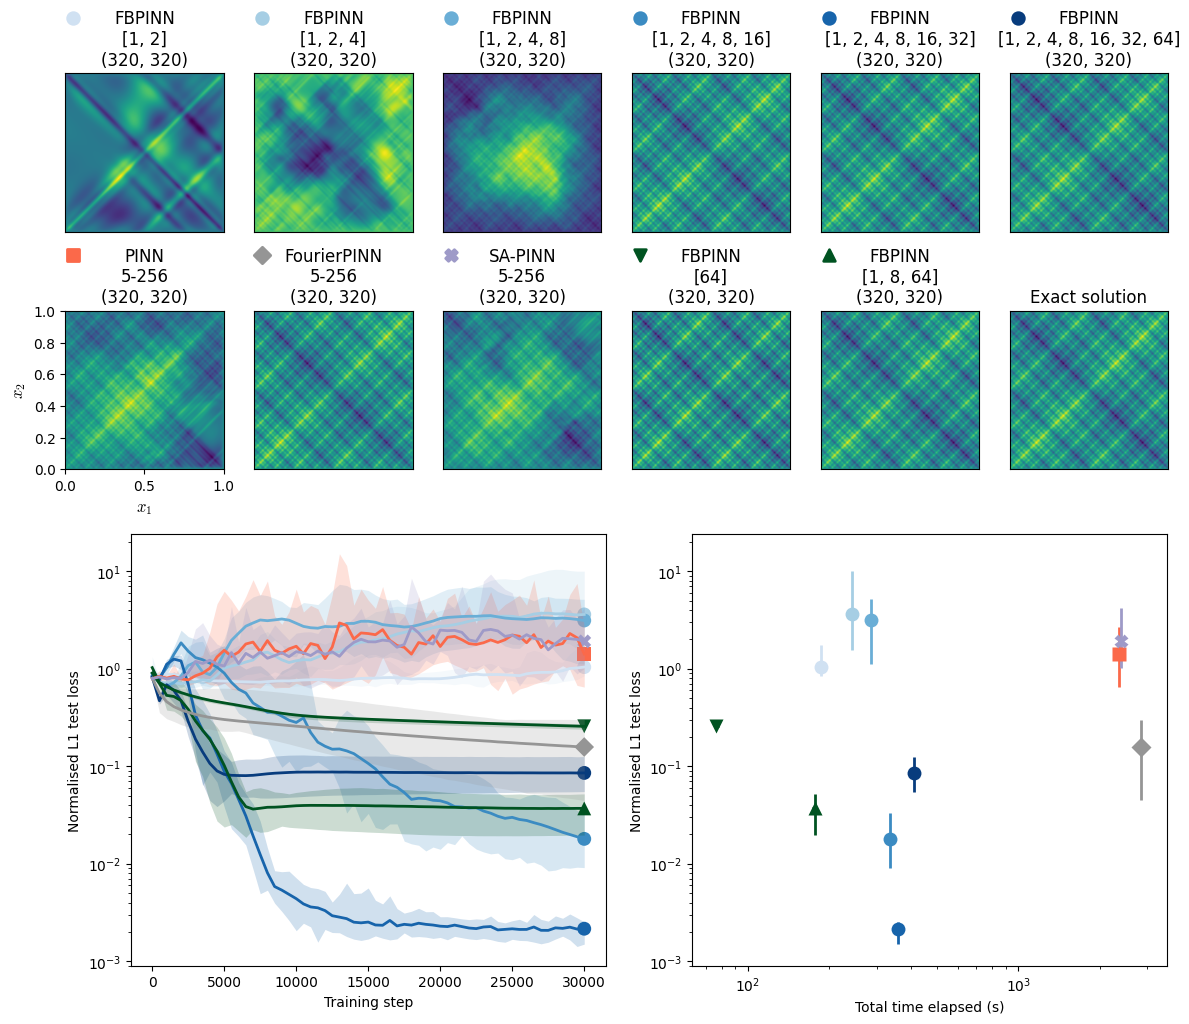

In [5]:
#########

## TEST 2: strong / weak scaling tests

# Laplace2D_multiscale strong scaling
tag = "strong"

problem=Laplace2D_multiscale
omegas=[2, 4, 8, 16, 32, 64]
unnorm=(0., 0.75)# unnorm

n_steps=30000# number training steps
n = (320,320)# number training points
n_test=(350,350)# number test points
lr = 1e-3# learning rate

h=1
w=1.9
p=16

# increase levels, but not collocation points
ls=[2, 3, 4, 5, 6, 7]# number of levels

#########
    
    
# plot setup
f = plt.figure(figsize=0.72*np.array([20,20]))
shape = (5,6)
# left, bottom, width, height
ax1 = f.add_axes([0.175,0.26,0.33,0.3])
ax2 = f.add_axes([0.565,0.26,0.33,0.3])
lx,ly=0.05,1.35

def p1(loc, ir):

    # load FBPINN 
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    u_test = FBPINN_solution(c, model)

    # plot convergence
    plt.sca(ax1)
    plot_l1(i, l1s, marker=marker, color=colorss[ic][ir], s=100, lw=2)
    plt.sca(ax2)
    scatter_l1(ts, l1s, marker=marker, color=colorss[ic][ir], s=10, lw=2)

    # plot solution
    plt.subplot2grid(shape, loc)
    plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
    plt.title(f"{"Fourier" if network is FourierFCN else ""}FBPINN\n{l}\n{n}")
    plt.scatter(lx,ly, clip_on=False, 
                marker=marker, facecolor=colorss[ic][ir], s=70, lw=2)
    fix_plot4()
    
ic=0
marker = "o"
network = FCN
for ip,l_ in enumerate(ls):
    l = [2**i for i in range(l_)]
    p1((0,ip), ip)
        
ic=1
for ip,(l, marker) in enumerate(zip([[64], [1,8,64]],
                                   ["v", "^"])):
    p1((1,3+ip), -1)


# load exact solution
c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
u_test = exact_solution(c, model)

# plot solution
plt.subplot2grid(shape, (1,5))
plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
plt.title("Exact solution")
fix_plot4()


h,p=5,256
for ip, (network, lr, marker, load_fn, pre, ic) in enumerate(zip(
                                            [FCN, FourierFCN, FCN],
                                            [1e-3, 1e-4, 1e-3],
                                            ["s", "D", "X"],
                                            [load_PINN, load_PINN, load_SelfAdaptivePINN],
                                            ["", "Fourier", "SA-"],
                                            [2, 3, 4])):
    
    # load PINN
    c, model, i, ts, l1s = load_fn(tag, problem, network, h, p, n, lr, n_seeds)
    u_test = PINN_solution(c, model)

    # plot convergence
    plt.sca(ax1)
    plot_l1(i, l1s, marker=marker, color=colorss[ic][2], s=100, lw=2)
    plt.sca(ax2)
    scatter_l1(ts, l1s, marker=marker, color=colorss[ic][2], s=10, lw=2)

    # plot solution
    plt.subplot2grid(shape, (1,ip))
    plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1))
    plt.title(f"{pre}PINN\n{h}-{p}\n{n}")
    plt.scatter(lx,ly, clip_on=False, 
                marker=marker, facecolor=colorss[ic][2], s=70, lw=2)
    if ip == 0:
        fix_plot2()
    else:
        fix_plot4()

# plot setup
plt.sca(ax1)
fix_plot(legend=False)
ylim = plt.ylim()
plt.sca(ax2)
fix_plot3(legend=False)
plt.ylim(ylim)
plt.subplots_adjust(hspace=0.5, wspace=0.1)
savefig()
plt.show()

## Laplace - weak scaling

30000.0 (61, 10) 0.00017857253 0.00055926084 26.281176 31.257698 FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_10-n_0.001-lr-9
30000.0 (61, 10) 0.00017857253 0.00055926084 26.281176 31.257698 FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_10-n_0.001-lr-9
30000.0 (61, 10) 0.0008514636 0.0017746693 26.821936 34.414417 FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_20-n_0.001-lr-9
30000.0 (61, 10) 0.0008514636 0.0017746693 26.821936 34.414417 FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_20-n_0.001-lr-9
30000.0 (61, 10) 0.0052484665 0.009824499 28.770891 33.5807 FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2, 4, 8]-levels_1.9-overlap_1-layers_16-hidden_40-n_0.001-lr-9
30000.0 (61, 10) 0.0052484665 0.009824499 28.770891 33.5807 FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2, 4, 8]-levels_1.9-overlap_1-layers_16-hidden_40-n_0.001-lr-9
30000.0 (61, 10) 0

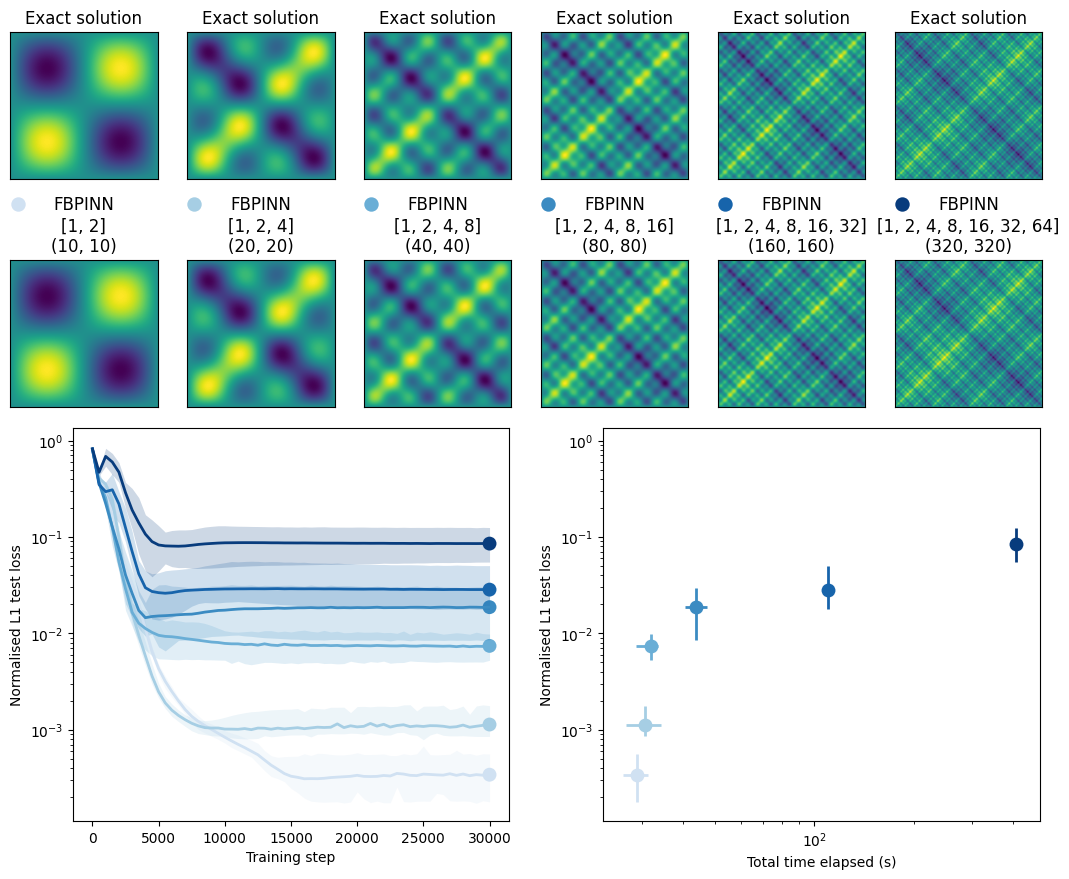

In [6]:
#########
tag = "weak"

lr = 1e-3# learning rate
#########

h=1
w=1.9
p=16

ns=[(10,10),(20,20),(40,40),(80,80),(160,160),(320,320)]


f = plt.figure(figsize=0.78*np.array([20,18]))
shape = (5,7)
# left, bottom, width, height
ax1 = f.add_axes([0.165,0.31,0.28,0.28])
ax2 = f.add_axes([0.505,0.31,0.28,0.28])
lx,ly=0.05,1.38
for ip,(l_,n) in enumerate(zip(ls, ns)):
    l = [2**i for i in range(l_)]

    # get exact solution
    network = FCN
    h,p = 1,16
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    u_exact = exact_solution(c, model)

    # plot exact solution
    plt.subplot2grid(shape, (0,ip))
    im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
    plt.title("Exact solution")
    fix_plot4()

    for ir,(network, h, p, label, marker, ic) in enumerate([
        (FCN, 1, 16, f"FBPINN\n{l}\n{n}", "o",0),
        #(SIREN, 1, 16, f"FBPINN (sin)\n{l}\n{n}", "D"),
        #(FCN, 5, 256, f"PINN\n{5}-{256}\n{n}", "s",2),
    ]):

        # load solution
        if "FBPINN" in label:
            c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
            u_test = FBPINN_solution(c, model)
        else:
            c, model, i, ts, l1s = load_PINN(tag, problem, network, h, p, n, lr, n_seeds)
            u_test = PINN_solution(c, model)

        # plot convergence
        plt.sca(ax1)
        plot_l1(i, l1s, marker=marker, color=colorss[ic][ip], s=100, lw=2)
        plt.sca(ax2)
        scatter_l1(ts, l1s, marker=marker, color=colorss[ic][ip], s=10, lw=2)

        # plot solution
        plt.subplot2grid(shape, (1+ir,ip))
        plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
        plt.scatter(lx,ly, clip_on=False, 
                    marker=marker, facecolor=colorss[ic][ip], s=70, lw=2)
        plt.title(label)
        fix_plot4()

plt.sca(ax1)
fix_plot(legend=False)
ylim = plt.ylim()
plt.sca(ax2)
fix_plot3(legend=False)
plt.ylim(ylim)
plt.subplots_adjust(hspace=0.35, wspace=0.2)
savefig()
plt.show()

FBPINN_weak_Laplace2D_multiscale_FCN_[1, 2, 4, 8, 16]-levels_1.9-overlap_1-layers_16-hidden_80-n_0.001-lr-0
(612500, 1)
(612500, 2)
(5, 350, 350) (350, 350)


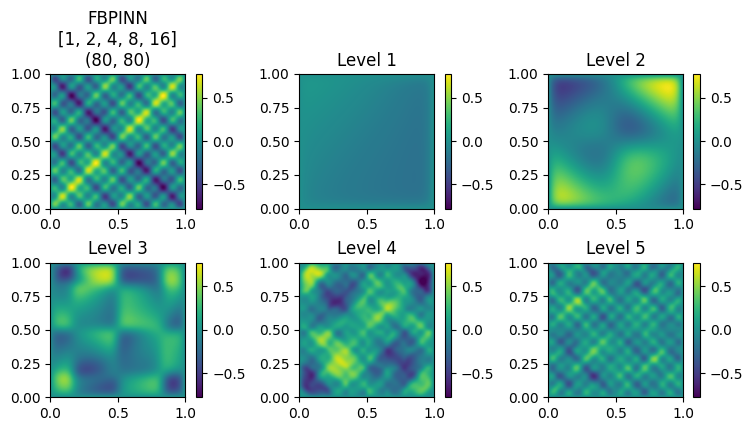

In [7]:
il = 3
l_, n = ls[il],ns[il]
l = [2**i for i in range(l_)]

c, model, *_ = load_FBPINN_(tag, problem, network, l, w, h, p, n, lr, seed=0)
print(c.run)

def plot_levels(c, model, l, n):
    all_params, domain = model[1], c.domain
    x_batch = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=c.n_test)
    active = jnp.ones((all_params["static"]["decomposition"]["m"]))
    problem, decomposition, network = c.problem, c.decomposition, c.network
    model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)
    takes, all_ims, (_, _, _, cut_all, _) = get_inputs(x_batch, active, all_params, decomposition)
    all_params_cut = {"static":cut_all(all_params["static"]),
                      "trainable":cut_all(all_params["trainable"])}
    _, _, us, ws, _ = FBPINN_model_jit(all_params_cut, x_batch, takes, model_fns)

    # apply POU only
    m_take, n_take, p_take, np_take, npou = takes
    u = jnp.concatenate([us, ws], axis=1)# (s, ud+1)
    u = jax.ops.segment_sum(u, p_take, indices_are_sorted=False, num_segments=len(np_take))# (_, ud+1)
    wp = u[:,-1:]
    u = u[:,:-1]/wp
    # at this point: pou-point list (i.e. summed over models in each point-pou, but not summed over pou)
    print(u.shape)

    pous = all_params["static"]["decomposition"]["subdomain"]["pou"][all_ims].astype(int)
    np_ = jnp.stack([n_take, pous[m_take,0]], axis=-1).astype(int)# points and pous
    npu,_ = jnp.unique(np_, axis=0, return_inverse=True)# unique points and pous (sorted), point-pou takes
    print(npu.shape)

    ud, n_ = all_params["static"]["problem"]["dims"][0], x_batch.shape[0]
    ul = jnp.full((npou, n_, ud), jnp.nan)
    ul = ul.at[npu[:,1], npu[:,0], :].set(u)/npou
    ulc = vmap(model_fns[-1], in_axes=(None,None,0))(all_params, x_batch, ul)# apply constraining function
    uc = model_fns[-1](all_params, x_batch, ul.sum(0))# apply constraining function
    ulc = ulc.reshape((-1,)+c.n_test)
    uc = uc.reshape(c.n_test)
    print(ulc.shape, uc.shape)
    
    plt.figure(figsize=0.7*np.array([13,6]))
    plt.subplot(2,3,1)
    plt.title(f"FBPINN\n{l}\n{n}")
    im = plt.imshow(uc.T, origin="lower", extent=(0,1,0,1))
    plt.colorbar()
    for ip,l in enumerate(ulc):
        plt.subplot(2,3,ip+2)
        plt.title(f"Level {ip+1}")
        plt.imshow(l.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
        plt.colorbar()
    plt.subplots_adjust(wspace=0.2,hspace=0.4)
    savefig("levels")
    plt.show()
    
plot_levels(c, model, l, n)

## Helmholtz - ablation

150000.0 (151, 10) 0.74826396 0.76074594 232.86797 243.39229 FBPINN_ablation_Helmholtz2D_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.75417614 0.76048636 208.3654 214.1915 FBPINN_ablation_Helmholtz2D_FCN_[2]-levels_1.9-overlap_1-layers_16-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.46049598 0.6299613 315.48737 319.7598 FBPINN_ablation_Helmholtz2D_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.5437101 0.70615184 169.52094 174.97827 FBPINN_ablation_Helmholtz2D_FCN_[4]-levels_1.9-overlap_1-layers_16-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.018738007 0.09394359 377.95578 388.35025 FBPINN_ablation_Helmholtz2D_FCN_[1, 2, 4, 8]-levels_1.9-overlap_1-layers_16-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.039636552 0.059296243 151.19537 156.7976 FBPINN_ablation_Helmholtz2D_FCN_[8]-levels_1.9-overlap_1-layers_16-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.011615845 0.040219735 406.78558 417.7755 FBPINN_abla

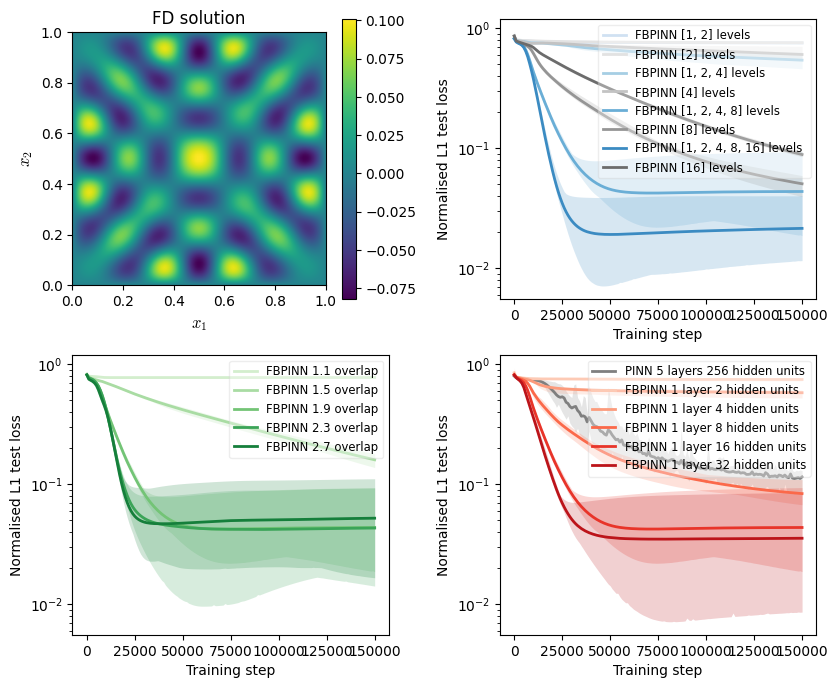

In [8]:
#########

network = FCN

tag = "ablation"

problem=Helmholtz2D
problem_init_kwargs = dict(c=1, w=2*np.pi/(0.2), sd=0.05)
unnorm=(0.00, 0.07)# unnorm

n_steps=150000# number training steps
n=(160,160)# number training points
n_test=(320,320)# number test points
lr = 1e-3# learning rate

h=1

ls=[2, 3, 4, 5]# number of levels
ws=[1.1, 1.5, 1.9, 2.3, 2.7]# overlap width
ps=[2, 4, 8, 16, 32]# number of hidden units
p0=[4, 1.9, 16]

#########


# plot ablations
plt.figure(figsize=0.8*np.array([12,10]))

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,2)
for ip,l_ in enumerate(ls):
    l = [2**i for i in range(l_)]
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    plot_l1(i, l1s, label=f"FBPINN {l} levels ", color=colors1[ip], lw=2)
    if l_ != 0:
        l = [2**(l_-1)]
        c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
        plot_l1(i, l1s, label=f"FBPINN {l} levels ", color=colors4[ip], lw=2)
    
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
ylim = list(plt.ylim())
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,3)
for ip,w in enumerate(ws):
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    plot_l1(i, l1s, label=f"FBPINN {w} overlap", color=colors2[ip], lw=2)
fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

l,w,p = [2**i for i in range(p0[0])], p0[1], p0[2]
plt.subplot(2,2,4)
h,p=5,256
c, model, i, ts, l1s = load_PINN(tag, problem, network, h, p, n, lr, n_seeds)
plot_l1(i, l1s, label=f"PINN {h} layers {p} hidden units", color="tab:grey", lw=2)
h,p=1,16

for ip,p in enumerate(ps):
    c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
    plot_l1(i, l1s, label=f"FBPINN {h} layer {p} hidden units", color=colors3[ip], lw=2)

fix_plot()
plt.legend(framealpha=0.35, fontsize="small", loc="upper right")
plt.ylim(ylim)

# plot exact solution
plt.subplot(2,2,1)
u_exact = exact_solution(c, model)
plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
plt.colorbar()
plt.title("FD solution")
fix_plot2()

plt.subplots_adjust(hspace=0.2, wspace=0.35)
savefig()
plt.show()

## Helmholtz - weak scaling

150000.0 (151, 10) 0.00023592195 0.0022394434 71.36689 76.51062 FBPINN_weak_1_Helmholtz2D_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_20-n_0.001-lr-9
150000.0 (151, 10) 0.00023592195 0.0022394434 71.36689 76.51062 FBPINN_weak_1_Helmholtz2D_FCN_[1, 2]-levels_1.9-overlap_1-layers_16-hidden_20-n_0.001-lr-9
150000.0 (151, 10) 0.0032700133 0.012663313 133.97467 135.81844 PINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_20-n_0.001-lr-9
150000.0 (151, 10) 0.00020990321 0.0018390481 152.62299 157.00307 PINN_weak_1_Helmholtz2D_FourierFCN_5-layers_256-hidden_20-n_0.0001-lr-9
0 0.4 256
150000.0 (151, 10) 0.0039701476 0.035493184 137.357 141.28987 SelfAdaptivePINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_20-n_0.001-lr-9
150000.0 (151, 10) 0.021043973 0.15988652 67.85996 77.65768 FBPINN_weak_1_Helmholtz2D_FCN_[1, 2, 4]-levels_1.9-overlap_1-layers_16-hidden_40-n_0.001-lr-9
150000.0 (151, 10) 0.021043973 0.15988652 67.85996 77.65768 FBPINN_weak_1_Helmholtz2D_FCN_[1, 2, 4]-levels_1.9-overlap_1-l

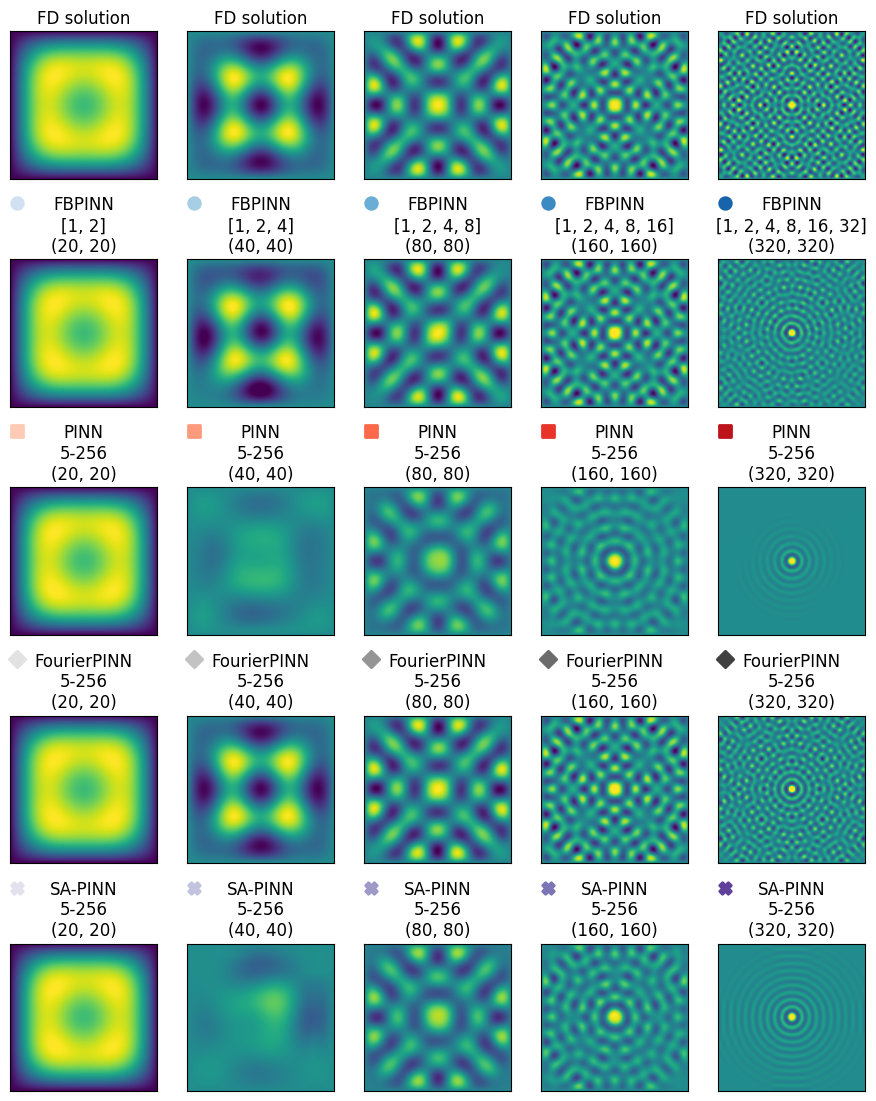

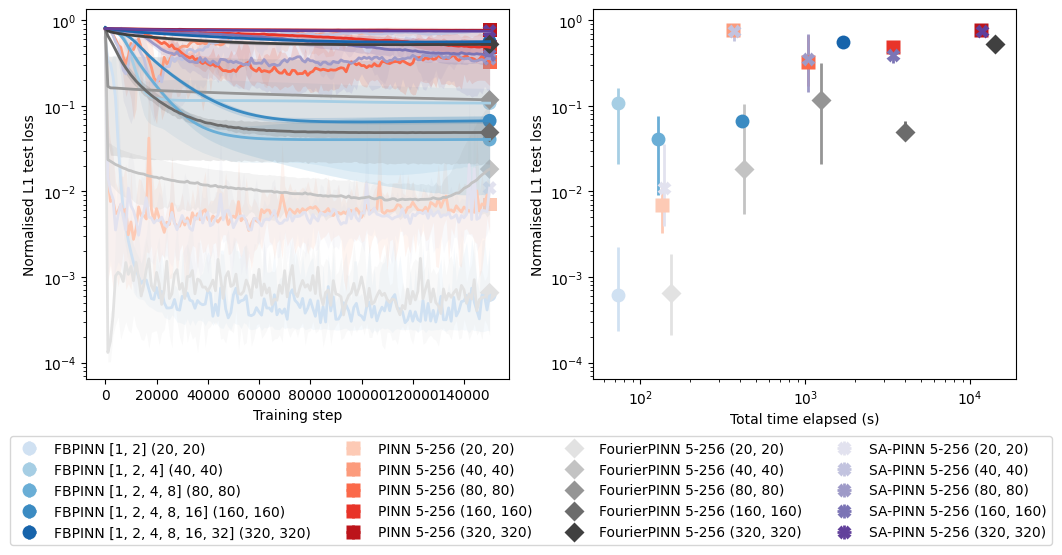

In [9]:
#########

w=1.9

# add omegas to problem, whilst increasing levels and collocation points
ls=[2, 3, 4, 5, 6]# number of levels
ns=[(20,20),(40,40),(80,80),(160,160),(320,320)]# number of collocation points


#########



def plot_weak():
    lr = 1e-3
    f1 = plt.figure(1, figsize=0.78*np.array([20,18]))
    f2 = plt.figure(2, figsize=0.6*np.array([20,8]))
    shape = (5,7)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    # left, bottom, width, height
    #ax1 = f.add_axes([0.17,0.03,0.22,0.22])
    #ax2 = f.add_axes([0.45,0.03,0.22,0.22])
    lx,ly=0.05,1.38
    for ip,(l_,n) in enumerate(zip(ls, ns)):
        l = [2**i for i in range(l_)]
        
        # get exact solution
        network = FCN
        h,p = 1,16
        c, model, i, ts, l1s = load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds)
        u_exact = exact_solution(c, model)
        
        # plot exact solution
        plt.figure(1)
        plt.subplot2grid(shape, (0,ip))
        im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
        plt.title("FD solution")
        fix_plot4()
        
        for ir,(network, h, p, lr, label, marker, ic, load_fn) in enumerate([
            (FCN, 1, 16, 1e-3, f"FBPINN\n{l}\n{n}", "o", 0, load_FBPINN),
            (FCN, 5, 256, 1e-3, f"PINN\n{5}-{256}\n{n}", "s", 2, load_PINN),
            (FourierFCN, 5, 256, 1e-4, f"FourierPINN\n{5}-{256}\n{n}", "D", 3, load_PINN),
            (FCN, 5, 256, 1e-3, f"SA-PINN\n{5}-{256}\n{n}", "X", 4, load_SelfAdaptivePINN),
        ]):
            
            # load solution
            if "FBPINN" in label:
                c, model, i, ts, l1s = load_fn(tag, problem, network, l, w, h, p, n, lr, n_seeds)
                u_test = FBPINN_solution(c, model)
            else:
                c, model, i, ts, l1s = load_fn(tag, problem, network, h, p, n, lr, n_seeds)
                u_test = PINN_solution(c, model)
    
            # plot convergence
            plt.sca(ax1)
            plot_l1(i, l1s, marker=marker, color=colorss[ic][ip], s=100, lw=2)
            plt.sca(ax2)
            scatter_l1(ts, l1s, marker=marker, color=colorss[ic][ip], s=10, lw=2, label=label.replace("\n", " "))

            # plot solution
            plt.figure(1)
            plt.subplot2grid(shape, (1+ir,ip))
            plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
            plt.scatter(lx,ly, clip_on=False, 
                        marker=marker, facecolor=colorss[ic][ip], s=70, lw=2)
            plt.title(label)
            fix_plot4()
    
    plt.figure(1)
    plt.subplots_adjust(hspace=0.35, wspace=0.2)
    savefig("solution")
    
    plt.figure(2)
    plt.sca(ax1)
    fix_plot(legend=False)
    ylim = plt.ylim()
    plt.sca(ax2)
    fix_plot3(legend=False)
    handles, labels = ax2.get_legend_handles_labels()
    order = np.concatenate([np.arange(0,4*5,4)+i for i in range(4)], axis=0)
    handles, labels = [handles[i] for i in order], [labels[i] for i in order]
    plt.legend(handles, labels, loc=(-1.38,-0.45), ncols=4)
    plt.ylim(ylim)
    savefig("loss")
    
    plt.show() 

for c_ in [1,]:
    tag = f"weak_{c_}"
    plot_weak()

150000.0 (151, 10) 0.0039701476 0.035493184 137.357 141.28987 SelfAdaptivePINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_20-n_0.001-lr-9
150000.0 (151, 10) 0.5708068 0.80981857 362.50363 374.94235 SelfAdaptivePINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_40-n_0.001-lr-9
150000.0 (151, 10) 0.14647032 0.6904127 1025.5565 1057.4109 SelfAdaptivePINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_80-n_0.001-lr-9
150000.0 (151, 10) 0.3171615 0.44906503 3371.4246 3419.095 SelfAdaptivePINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_160-n_0.001-lr-9
150000.0 (151, 10) 0.7405454 0.7579956 11778.557 11950.1 SelfAdaptivePINN_weak_1_Helmholtz2D_FCN_5-layers_256-hidden_320-n_0.001-lr-9


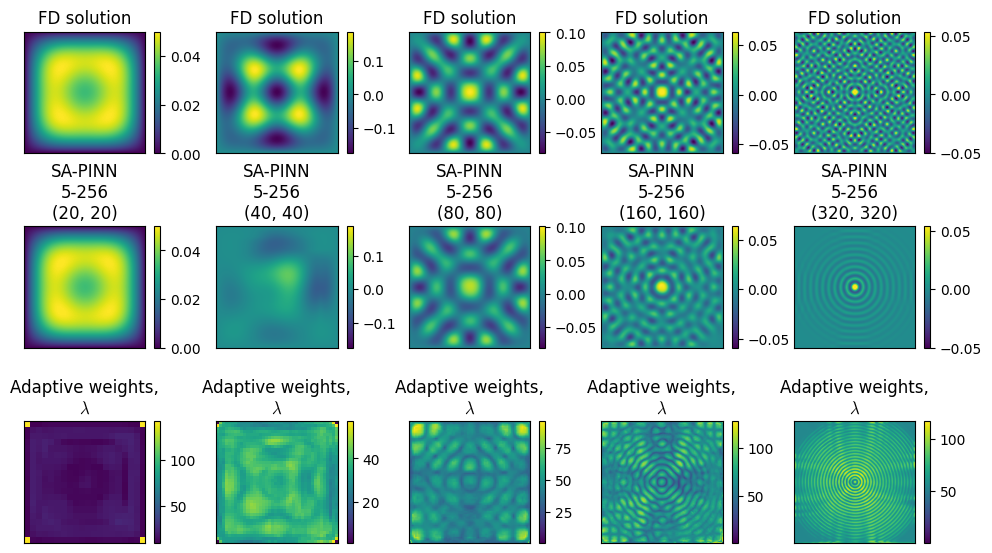

In [10]:
tag = f"weak_{1}"
problem=Helmholtz2D
lr=1e-3

plt.figure(figsize=0.78*np.array([22,15]))
shape = (5,7)
ns=[(20,20),(40,40),(80,80),(160,160),(320,320)]# number of collocation points
for ip,n in enumerate(ns):
    network, h, p, label, marker, ic, load_fn = FCN, 5, 256, f"SA-PINN\n{5}-{256}\n{n}", "X", 4, load_SelfAdaptivePINN
    c, model, i, ts, l1s = load_fn(tag, problem, network, h, p, n, lr, n_seeds)
    u_test = PINN_solution(c, model)
    u_exact = exact_solution(c, model)
    weights = model[1]["trainable"]["problem"]["adaptive_weights"][0]

    plt.subplot2grid(shape, (0,ip))
    im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
    plt.colorbar()
    fix_plot4()
    plt.title("FD solution")

    plt.subplot2grid(shape, (1,ip))
    plt.imshow(u_test.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
    plt.colorbar()
    fix_plot4()
    plt.title(label)

    plt.subplot2grid(shape, (2,ip))
    plt.imshow(weights.T, origin="lower", extent=(0,1,0,1))
    plt.colorbar()
    fix_plot4()
    plt.title("Adaptive weights,\n$\\mathbf{\\lambda}$")

plt.subplots_adjust(hspace=0.6, wspace=0.1)
savefig("weights")
plt.show()